## 必要なデータの準備

In [0]:
# Google画像検索ライブラリの追加
!pip install google_images_download

In [0]:
# Tensorflowのライブラリのダウンロード
!git clone https://github.com/tensorflow/models.git
# パリピ判定用学習データのダウンロード
!git clone https://github.com/s-ishikawa-0921/paripi_object_detection.git

In [0]:
# PYTHONPATHの設定
%set_env PYTHONPATH=/env/python:/content/models/research:/content/models/research/slim:/content/models/research/object_detection

In [0]:
# モデルの初期化
%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.

In [0]:
# 標準学習データのダウンロード
%cd /content 
! wget http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v1_coco_2018_01_28.tar.gz
!tar -xvf ssd_mobilenet_v1_coco_2018_01_28.tar.gz
!mv ssd_mobilenet_v1_coco_2018_01_28 ssd

## パリピチェック用学習データの作成

### 学習データの作成

In [0]:
# google画像検索からパリピとエンジニアの画像を取得
!rm -rf /content/paripi_object_detection/paripi_check/downloads
!googleimagesdownload -o /content/paripi_object_detection/paripi_check/downloads -i paripi -f jpg -t photo -k パリピ
!googleimagesdownload -o /content/paripi_object_detection/paripi_check/downloads -i imopi -f jpg -t photo -k エンジニア
#!googleimagesdownload -o /content/paripi_object_detection/paripi_check/downloads -i imopi -f jpg -t photo -k オタク

In [0]:
%cd /content/paripi_object_detection
!rm -rf /content/paripi_object_detection/paripi_check/train_images

import importlib
import sys
sys.path.append('/content/models/research')
sys.path.append('/content/models/research/object_detection')

import object_detection_util
importlib.reload(object_detection_util)

#パリピ画像から人物のみを抽出
object_detection_util.trim(
    '/content/paripi_object_detection/paripi_check/downloads/paripi/',
    '/content/paripi_object_detection/paripi_check/train_images/paripi/',
    '/content/ssd/frozen_inference_graph.pb',
    '/content/models/research/object_detection/data/mscoco_label_map.pbtxt'
)
#非パリピ画像から人物のみを抽出
object_detection_util.trim(
    '/content/paripi_object_detection/paripi_check/downloads/imopi/',
    '/content/paripi_object_detection/paripi_check/train_images/imopi/',
    '/content/ssd/frozen_inference_graph.pb',
    '/content/models/research/object_detection/data/mscoco_label_map.pbtxt'
)

In [0]:
# 抽出した画像を圧縮（確認用）
%cd /content/paripi_object_detection/paripi_check/downloads
!tar -zcvf paripi.tar.gz paripi
!tar -zcvf imopi.tar.gz imopi

%cd /content/paripi_object_detection/paripi_check/train_images
!tar -zcvf paripi.tar.gz paripi
!tar -zcvf imopi.tar.gz imopi

In [0]:
# 学習プログラムのダウンロード
%cd /content/paripi_object_detection/paripi_check/
!wget https://github.com/tensorflow/hub/raw/master/examples/image_retraining/retrain.py
!wget https://github.com/tensorflow/tensorflow/raw/master/tensorflow/examples/label_image/label_image.py

In [0]:
# 学習
%cd /content/paripi_object_detection/paripi_check/
!python retrain.py --bottleneck_dir=bottlenecks \
  --how_many_training_steps=100 \
  --model_dir=inception \
  --summaries_dir=training_summaries/basic \
  --output_graph=retrained_graph.pb \
  --output_labels=retrained_labels.txt \
  --image_dir=/content/paripi_object_detection/paripi_check/train_images

### 動作検証

/content/paripi_object_detection


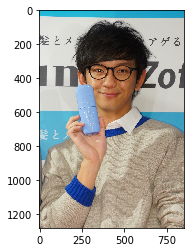

load graph /content/paripi_object_detection/paripi_check/retrained_graph.pb
パリピ率 : 4%


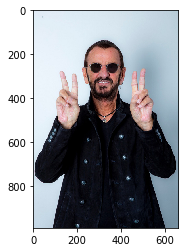

パリピ率 : 73%


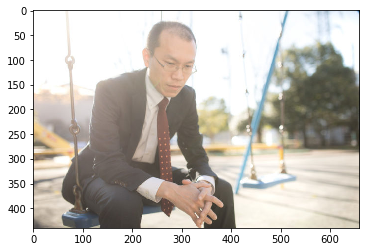

パリピ率 : -50%


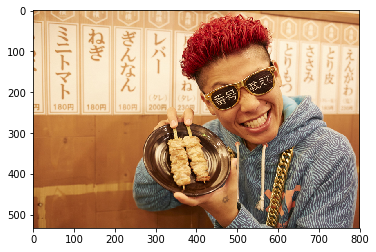

パリピ率 : 74%


In [14]:
# 動作検証
%cd /content/paripi_object_detection

import importlib,cv2,sys,os
from matplotlib import pyplot as plt

sys.path.append('/content/models/research')
sys.path.append('/content/models/research/object_detection')

import object_detection_util
importlib.reload(object_detection_util)

TEST_DIR = '/content/paripi_object_detection/paripi_check/test/'
for file_name in os.listdir(TEST_DIR):
  
  out_img = cv2.imread(TEST_DIR + file_name)
  plt.imshow(cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB))
  plt.show() 
  
  data = object_detection_util.check(
      TEST_DIR+file_name,
      '/content/paripi_object_detection/paripi_check/retrained_graph.pb',
      '/content/paripi_object_detection/paripi_check/retrained_labels.txt'
  )
  print('パリピ率 : ' + str(round((data['paripi'] - 0.5) * 2 * 100)) + '%')
  #print('パリピ率 : ' + str(data['paripi']))

## パリピモザイク用学習データの作成

### 学習データの作成

In [0]:
# tf_recordの生成
%cd /content/paripi_object_detection/paripi_mosaic/
!python create_tf_record.py \
    --annotations_dir=`pwd`/annotations \
    --images_dir=`pwd`/images \
    --output_dir=`pwd` \
    --label_map_path=paripi_label_map.pbtxt

In [0]:
#通常の学習
%cd /content/models/research/
!rm -rf /content/paripi_object_detection/paripi_mosaic/train
!mkdir /content/paripi_object_detection/paripi_mosaic/train
!python object_detection/model_main.py \
    --pipeline_config_path=/content/paripi_object_detection/paripi_mosaic/ssd_mobilenet_v1_coco.config \
    --model_dir=/content/paripi_object_detection/paripi_mosaic/train \
    --num_train_steps=30000 \
    --num_eval_steps=2000 \
    --logtostderr

In [0]:
# 学習データの生成
# /content/paripi_object_detection/paripi_mosaic/train/model.ckpt-NNN は結果により変更
%cd /content/models/research/
!rm -rf /content/paripi_object_detection/paripi_mosaic/exported_graphs
!mkdir /content/paripi_object_detection/paripi_mosaic/exported_graphs
!python object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path=/content/paripi_object_detection/paripi_mosaic/ssd_mobilenet_v1_coco.config \
    --trained_checkpoint_prefix=/content/paripi_object_detection/paripi_mosaic/train/model.ckpt-448 \
    --output_directory=/content/paripi_object_detection/paripi_mosaic/exported_graphs

### 動作検証

/content/models/research/object_detection


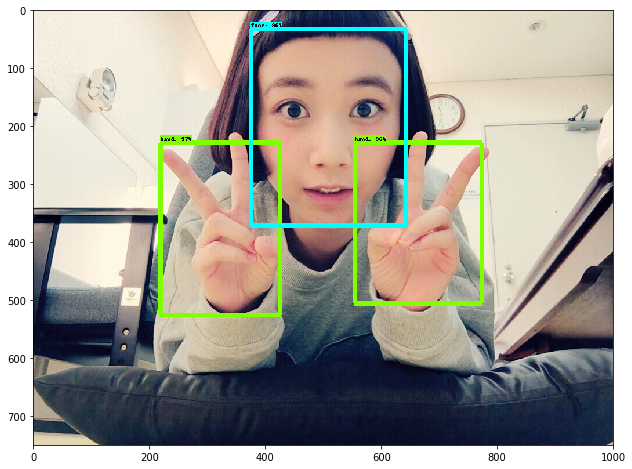

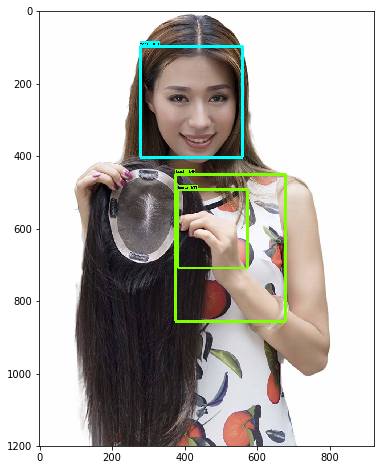

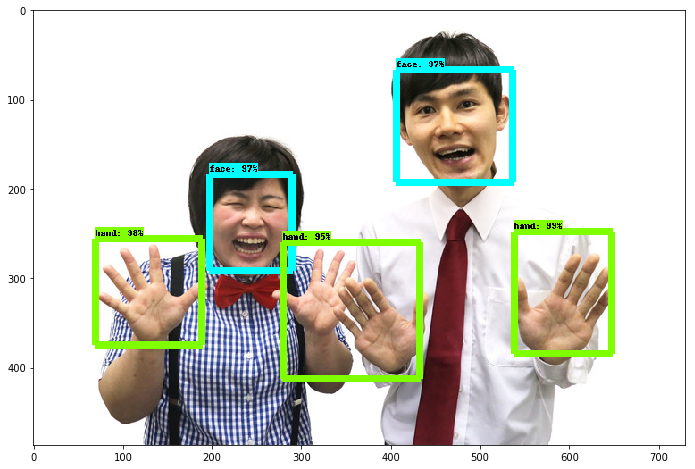

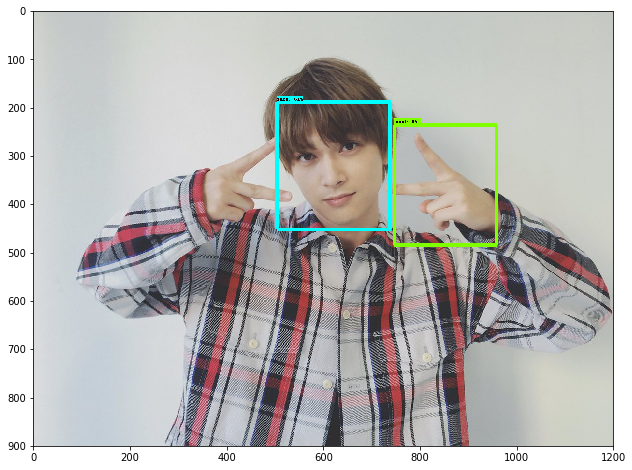

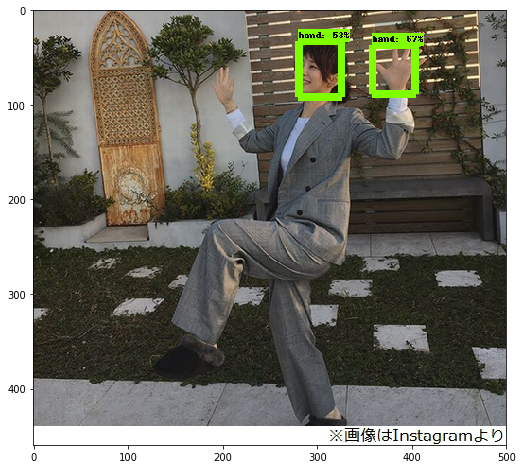

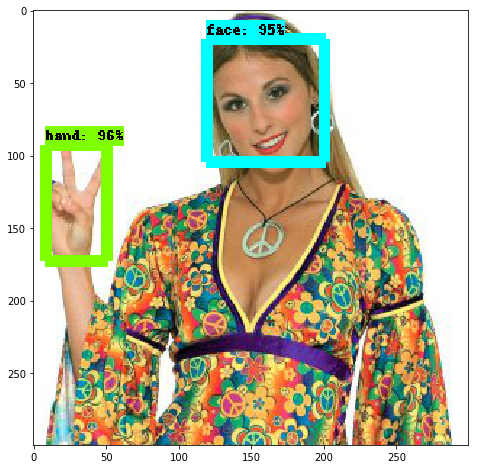

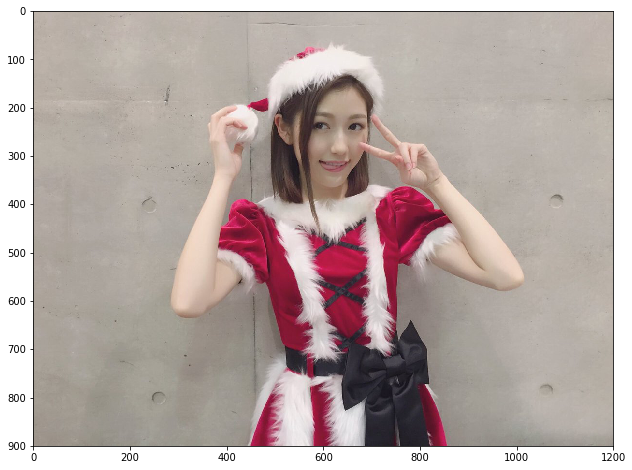

In [11]:
%cd /content/models/research/object_detection/
!rm -rf /content/paripi_object_detection/data/test/.ipynb_checkpoints
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

#if StrictVersion(tf.__version__) < StrictVersion('1.9.0'):
#  raise ImportError('Please upgrade your TensorFlow installation to v1.9.* or later!')
  
  
# This is needed to display the images.
%matplotlib inline

from utils import label_map_util

from utils import visualization_utils as vis_util

# What model to download.
#MODEL_NAME = 'ssd_mobilenet_v1_coco_2017_11_17'
#MODEL_FILE = MODEL_NAME + '.tar.gz'
#DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = '/content/paripi_object_detection/paripi_mosaic/exported_graphs/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = '/content/paripi_object_detection/paripi_mosaic/paripi_label_map.pbtxt'


#opener = urllib.request.URLopener()
#opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
#tar_file = tarfile.open(MODEL_FILE)
#for file in tar_file.getmembers():
#  file_name = os.path.basename(file.name)
#  if 'frozen_inference_graph.pb' in file_name:
#    tar_file.extract(file, os.getcwd())

detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = '/content/paripi_object_detection/paripi_mosaic/test/'
#TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 3) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

file_list = os.listdir(PATH_TO_TEST_IMAGES_DIR)
for file_name in file_list:
  #print(PATH_TO_TEST_IMAGES_DIR + file_name)
  image = Image.open(PATH_TO_TEST_IMAGES_DIR + file_name)

  #for image_path in TEST_IMAGE_PATHS:
  #  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)

## その他

In [0]:
%cd /content/paripi_object_detection/
!git pull

In [0]:
!git reset --mixed HEAD